In [16]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/2-Marketing_Prediction")

data = pd.read_csv("data.csv", na_values=["", "NA"])

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [8, 6]  # Default figure size
plt.rcParams['figure.dpi'] = 100  # Controls display resolution

#### data preview

In [17]:
print(data.head())

   id  age      dist       income gender marital_status  target
0   1   73  4.371654    90-99,999      M              S       1
1   2   89  1.582733  100-149,999      M            NaN       1
2   3   85  1.223810    10-19,999      F              S       1
3   4   76  2.962427    90-99,999      M              M       1
4   5   76  2.594408    10-19,999      M              S       1


#### Income: continuous, distance: integer, gender/marital_status/target: binary.

In [18]:
import pandas as pd
import numpy as np

# Replace missing or empty values in columns 4, 5, 6 with "unknown"
data.iloc[:, [3, 4, 5]] = data.iloc[:, [3, 4, 5]].applymap(lambda x: "unknown" if pd.isna(x) or x == "" else x)

income_mapping = {
    "unknown": 55000,
    "Under $10k": 5000,
    "10-19,999": 15000,
    "20-29,999": 25000,
    "30-39,999": 35000,
    "40-49,999": 45000,
    "50-59,999": 55000,
    "60-69,999": 65000,
    "70-79,999": 75000,
    "80-89,999": 85000,
    "90-99,999": 95000,
    "100-149,999": 125000,
    "150 - 174,999": 162500,
    "175 - 199,999": 187500,
    "200 - 249,999": 225000,
    "250k+": 250000
}
data["income"] = data["income"].map(income_mapping).astype(int)

# Replace gender with 1 for male, 0 for female, and 0 for unknown
gender_mapping = {"M": 1, "F": 0, "unknown": 0}
data["gender"] = data["gender"].map(gender_mapping).astype(int)

# Replace marital_status with 1 for married, 0 for single, and 1 for unknown
marital_status_mapping = {"M": 1, "S": 0, "unknown": 1}
data["marital_status"] = data["marital_status"].map(marital_status_mapping).astype(int)

# Convert target to categorical values (0 or 1)
data["target"] = data["target"].astype(int)

# Convert distance (dist) column to integer
data["dist"] = data["dist"].astype(int)

#### Examine strength of continuous predictors within data set by plotting observed probability of response corresponding to predictor values.   

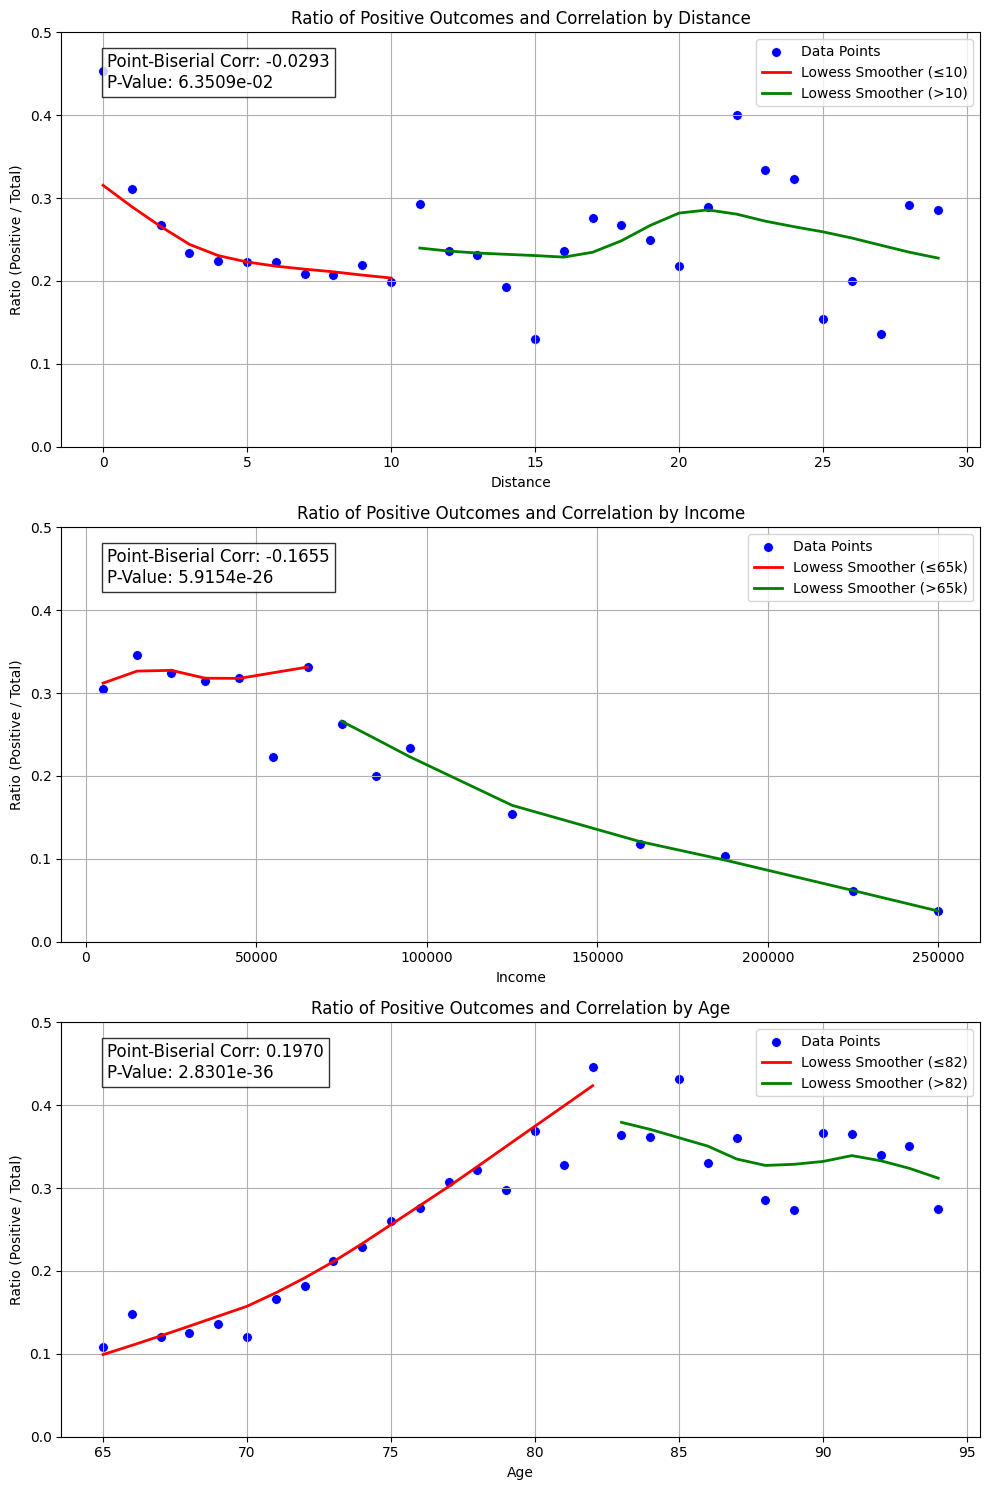

In [19]:
import seaborn as sns
from scipy.stats import pointbiserialr

def plot_ratio_positive_negative_with_corr(df, continuous_var, categorical_var='target', positive_value=1, negative_value=0):
    grouped = df.groupby([continuous_var, categorical_var]).size().reset_index(name='count')
    pivot = grouped.pivot(index=continuous_var, columns=categorical_var, values='count').fillna(0)
    
    positive_counts = pivot[positive_value] if positive_value in pivot.columns else 0
    total_counts = positive_counts + pivot[negative_value] if negative_value in pivot.columns else positive_counts
    ratio = positive_counts / (total_counts + 1e-9)
    
    plot_df = pd.DataFrame({continuous_var: ratio.index, 'ratio_positive_negative': ratio.values})
    return plot_df, *pointbiserialr(df[continuous_var], df[categorical_var])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

dist_plot_df, dist_corr, dist_p = plot_ratio_positive_negative_with_corr(data, 'dist', 'target')
sns.scatterplot(x='dist', y='ratio_positive_negative', data=dist_plot_df, color='blue', s=50, label='Data Points', ax=ax1)

dist_plot_df_lt10 = dist_plot_df[dist_plot_df['dist'] <= 10]
dist_plot_df_gt10 = dist_plot_df[dist_plot_df['dist'] > 10]

sns.regplot(x='dist', y='ratio_positive_negative', data=dist_plot_df_lt10, scatter=False,
            lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother (≤10)', ax=ax1)
sns.regplot(x='dist', y='ratio_positive_negative', data=dist_plot_df_gt10, scatter=False,
            lowess=True, color='green', line_kws={'lw': 2}, label='Lowess Smoother (>10)', ax=ax1)

ax1.text(0.05, 0.95, f'Point-Biserial Corr: {dist_corr:.4f}\nP-Value: {dist_p:.4e}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
ax1.set_title('Ratio of Positive Outcomes and Correlation by Distance')
ax1.set_xlabel('Distance')
ax1.set_ylabel('Ratio (Positive / Total)')
ax1.set_ylim(0, 0.50)
ax1.legend()
ax1.grid()

income_plot_df, income_corr, income_p = plot_ratio_positive_negative_with_corr(data, 'income', 'target')
sns.scatterplot(x='income', y='ratio_positive_negative', data=income_plot_df, color='blue', s=50, label='Data Points', ax=ax2)

income_plot_df_lt65k = income_plot_df[income_plot_df['income'] <= 65000]
income_plot_df_gt65k = income_plot_df[income_plot_df['income'] > 65000]

sns.regplot(x='income', y='ratio_positive_negative', data=income_plot_df_lt65k, scatter=False,
            lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother (≤65k)', ax=ax2)
sns.regplot(x='income', y='ratio_positive_negative', data=income_plot_df_gt65k, scatter=False,
            lowess=True, color='green', line_kws={'lw': 2}, label='Lowess Smoother (>65k)', ax=ax2)

ax2.text(0.05, 0.95, f'Point-Biserial Corr: {income_corr:.4f}\nP-Value: {income_p:.4e}', transform=ax2.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
ax2.set_title('Ratio of Positive Outcomes and Correlation by Income')
ax2.set_xlabel('Income')
ax2.set_ylabel('Ratio (Positive / Total)')
ax2.set_ylim(0, 0.50)
ax2.legend()
ax2.grid()

age_plot_df, age_corr, age_p = plot_ratio_positive_negative_with_corr(data, 'age', 'target')
sns.scatterplot(x='age', y='ratio_positive_negative', data=age_plot_df, color='blue', s=50, label='Data Points', ax=ax3)

age_plot_df_lt82 = age_plot_df[age_plot_df['age'] <= 82]
age_plot_df_gt82 = age_plot_df[age_plot_df['age'] > 82]

sns.regplot(x='age', y='ratio_positive_negative', data=age_plot_df_lt82, scatter=False,
            lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother (≤82)', ax=ax3)
sns.regplot(x='age', y='ratio_positive_negative', data=age_plot_df_gt82, scatter=False,
            lowess=True, color='green', line_kws={'lw': 2}, label='Lowess Smoother (>82)', ax=ax3)

ax3.text(0.05, 0.95, f'Point-Biserial Corr: {age_corr:.4f}\nP-Value: {age_p:.4e}', transform=ax3.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
ax3.set_title('Ratio of Positive Outcomes and Correlation by Age')
ax3.set_xlabel('Age')
ax3.set_ylabel('Ratio (Positive / Total)')
ax3.set_ylim(0, 0.50)
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()

These predictors are relatively week individually within the aggregate of the data. They also have mixed effects.

In model testing, "knotting" only the variable age yielded the best results. 

In [20]:
data['age_lt80'] = np.where(data['age'] < 80, data['age'], 82)
data['age_ge80'] = np.where(data['age'] >= 80, data['age'] - 82, 0)
print(data.head())

   id  age  dist  income  gender  marital_status  target  age_lt80  age_ge80
0   1   73     4   95000       1               0       1        73         0
1   2   89     1  125000       1               1       1        82         7
2   3   85     1   15000       0               0       1        82         3
3   4   76     2   95000       1               1       1        76         0
4   5   76     2   15000       1               0       1        76         0


#### Examine strength of categorical predictors while checking for interactions.

In [21]:
predictors = pd.DataFrame({
    'Single': [data[(data['gender'] == 0) & (data['marital_status'] == 0)]['target'].mean(),
               data[(data['gender'] == 1) & (data['marital_status'] == 0)]['target'].mean()],
    'Married': [data[(data['gender'] == 0) & (data['marital_status'] == 1)]['target'].mean(),
                data[(data['gender'] == 1) & (data['marital_status'] == 1)]['target'].mean()],
    'Overall': [data[data['gender'] == 0]['target'].mean(),
                data[data['gender'] == 1]['target'].mean()]
}, index=['Female', 'Male'])

print("Proportion of Gender that Responded") 
print(predictors)

Proportion of Gender that Responded
          Single   Married  Overall
Female  0.224093  0.219920  0.22151
Male    0.214156  0.304501  0.27927


Gender effects relationship between marital_status and response. 

##### Evaluate Logistic Regression Model with every possible combination of interaction terms and select combination with best performance. Model performance is measured by the percentage of total responses captured among the top 40% of customers, ranked by predicted response probability visualized in a lift chart. 

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations

base_features = ['age_lt80', 'age_ge80', 'dist', 'income', 'gender', 'marital_status']
interaction_terms = [
    ('age_lt80', 'dist'), ('age_lt80', 'income'), ('age_lt80', 'gender'), ('age_lt80', 'marital_status'),
    ('age_ge80', 'dist'), ('age_ge80', 'income'), ('age_ge80', 'gender'), ('age_ge80', 'marital_status'),
    ('dist', 'income'), ('dist', 'gender'), ('dist', 'marital_status'),
    ('income', 'gender'), ('income', 'marital_status'), ('gender', 'marital_status')
]

results = []

for r in range(len(interaction_terms) + 1):
    for terms in combinations(interaction_terms, r):
        X = data[base_features].copy()
        
        for t1, t2 in terms:
            X[f'{t1}_{t2}'] = X[t1] * X[t2]
            
        y = data['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)
        y_pred_proba_test = model.predict(sm.add_constant(X_test))
        
        test_data = pd.DataFrame({'target': y_test, 'predicted_probs': y_pred_proba_test})
        test_data_sorted = test_data.sort_values('predicted_probs', ascending=False)
        
        total_pos = test_data_sorted['target'].sum()
        n_rows = len(test_data_sorted)
        cutoff_index = int(0.4 * n_rows)
        lift_at_40 = test_data_sorted.iloc[:cutoff_index]['target'].sum() / total_pos * 100
        
        results.append({
            'num_interactions': len(terms),
            'interactions': terms,
            'lift_at_40': lift_at_40
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('lift_at_40', ascending=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("\nTop 10 interaction combinations by lift at 40%:")
display(results_df.head(10))


Top 10 interaction combinations by lift at 40%:


,num_interactions,interactions,lift_at_40
6195,6,"((age_lt80, marital_status), (age_ge80, income), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",62.672811
6261,6,"((age_lt80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender), (gender, marital_status))",62.211982
7977,7,"((age_lt80, dist), (age_lt80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender), (gender, marital_status))",62.211982
7825,7,"((age_lt80, dist), (age_lt80, marital_status), (age_ge80, dist), (age_ge80, marital_status), (dist, income), (dist, marital_status), (income, gender))",62.211982
4366,6,"((age_lt80, dist), (age_lt80, marital_status), (age_ge80, dist), (dist, income), (dist, marital_status), (income, gender))",62.211982
740,4,"((age_lt80, dist), (dist, income), (dist, marital_status), (income, gender))",62.211982
12247,8,"((age_lt80, income), (age_lt80, marital_status), (age_ge80, income), (age_ge80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",62.211982
9755,7,"((age_lt80, marital_status), (age_ge80, income), (dist, income), (dist, gender), (dist, marital_status), (income, gender), (gender, marital_status))",62.211982
12263,8,"((age_lt80, income), (age_lt80, marital_status), (age_ge80, income), (dist, income), (dist, gender), (dist, marital_status), (income, gender), (gender, marital_status))",62.211982
6427,6,"((age_ge80, income), (age_ge80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",62.211982


#### Logistic Regression Model evaluated with best combination of interaction terms.

Yield at 40%: 62.7%


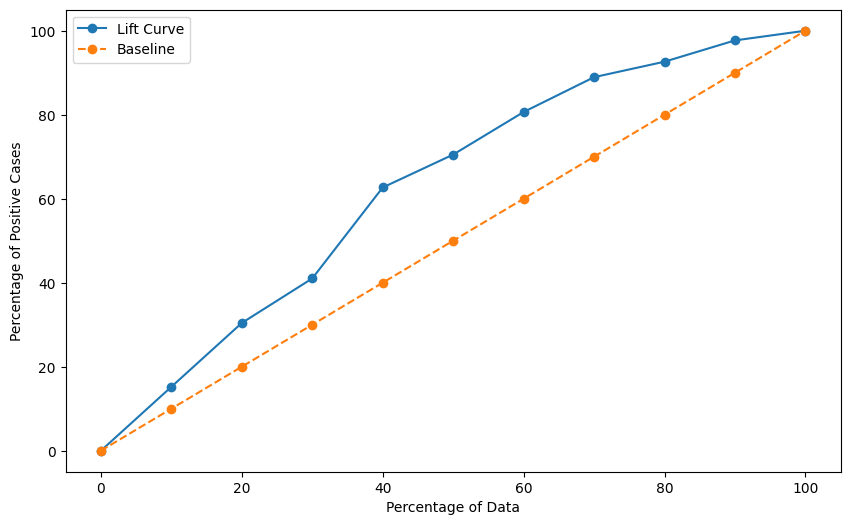

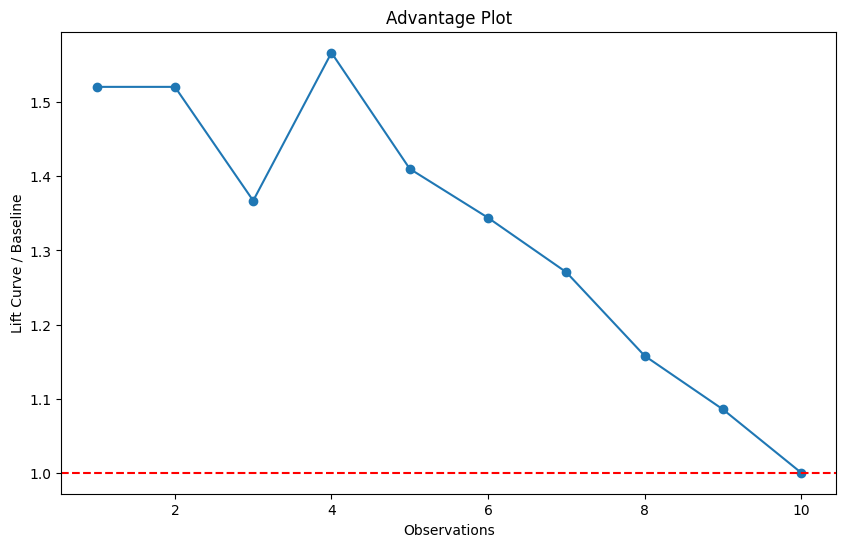

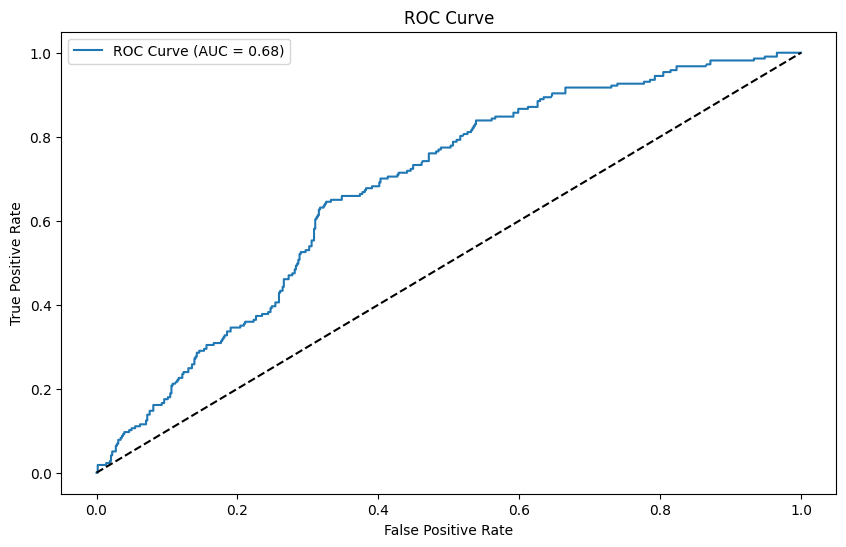


Top 10 observations by predicted probability:


,target,predicted_probs,age_lt80,age_ge80,dist,income,gender,marital_status,age_lt80_marital_status,age_ge80_income,dist_income,dist_gender,dist_marital_status,income_gender
1405,0,0.579455,82,-2,2,5000,1,1,82,-10000,10000,2,2,5000
279,1,0.562695,82,-2,5,15000,1,1,82,-30000,75000,5,5,15000
2586,1,0.560023,82,-1,0,15000,1,1,82,-15000,0,0,0,15000
3331,1,0.558055,82,-1,3,15000,1,1,82,-15000,45000,3,3,15000
1211,1,0.551534,82,-2,22,15000,1,1,82,-30000,330000,22,22,15000
184,0,0.550060,82,3,1,5000,1,1,82,15000,5000,1,1,5000
3379,0,0.546820,82,0,11,15000,1,1,82,0,165000,11,11,15000
893,0,0.541995,82,-1,3,25000,1,1,82,-25000,75000,3,3,25000
2682,0,0.539455,82,2,4,15000,1,1,82,30000,60000,4,4,15000
63,0,0.533752,82,-1,0,35000,1,1,82,-35000,0,0,0,35000



Bottom 10 observations by predicted probability:


,target,predicted_probs,age_lt80,age_ge80,dist,income,gender,marital_status,age_lt80_marital_status,age_ge80_income,dist_income,dist_gender,dist_marital_status,income_gender
3284,0,0.029019,65,0,23,162500,1,1,65,0,3737500,23,23,162500
976,0,0.028952,68,0,7,225000,0,1,68,0,1575000,0,7,0
2335,0,0.028776,69,0,8,225000,0,1,69,0,1800000,0,8,0
1532,0,0.023675,65,0,4,250000,0,1,65,0,1000000,0,4,0
1916,0,0.022613,70,0,17,187500,0,1,70,0,3187500,0,17,0
538,0,0.022580,68,0,7,250000,0,1,68,0,1750000,0,7,0
990,0,0.019946,66,0,18,225000,1,1,66,0,4050000,18,18,225000
3594,0,0.017780,82,11,18,225000,0,0,0,2475000,4050000,0,0,0
3052,0,0.016003,67,0,18,187500,0,1,67,0,3375000,0,18,0
2476,0,0.010245,65,0,12,250000,0,1,65,0,3000000,0,12,0


In [23]:
best_terms = results_df.iloc[0]['interactions']

X = data[base_features].copy()
for t1, t2 in best_terms:
    X[f'{t1}_{t2}'] = X[t1] * X[t2]

y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)
y_pred_proba_test = model.predict(sm.add_constant(X_test))

test_data = pd.DataFrame({'target': y_test, 'predicted_probs': y_pred_proba_test})
for col in X_test.columns:
    test_data[col] = X_test[col]
test_data_sorted = test_data.sort_values('predicted_probs', ascending=False)

total_pos = test_data_sorted['target'].sum()
n_rows = len(test_data_sorted)
deciles = np.linspace(0, n_rows, 11, dtype=int)
lift_curve = [test_data_sorted.iloc[:i]['target'].sum() / total_pos * 100 for i in deciles]
baseline = np.linspace(0, 100, 11)

print(f'Yield at 40%: {lift_curve[4]:.1f}%')

plt.figure(figsize=(10, 6))
plt.plot(baseline, lift_curve, marker='o', label='Lift Curve')
plt.plot(baseline, baseline, linestyle='--', marker='o', label='Baseline')
plt.xlabel('Percentage of Data')
plt.ylabel('Percentage of Positive Cases')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(11), np.array(lift_curve) / baseline, marker='o')
plt.axhline(y=1, linestyle='--', color='r')
plt.xlabel('Observations')
plt.ylabel('Lift Curve / Baseline')
plt.title('Advantage Plot')
plt.show()

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("\nTop 10 observations by predicted probability:")
display(test_data_sorted[['target', 'predicted_probs'] + list(X_test.columns)].head(10))

print("\nBottom 10 observations by predicted probability:")
display(test_data_sorted[['target', 'predicted_probs'] + list(X_test.columns)].tail(10))
